## feature Extraction .

<h3><strong> <mark> 1- SUM(area of closed chars)/(area of the image) </mark> <strong></h3>
* to make the feature invariant to the size of the image. we can use the ratio of the sum of the area of the closed characters to the area of the image.

* 

In [2]:
import skimage as ski 
from skimage.feature import local_binary_pattern
from skimage import io, measure, color , util, morphology
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

In [3]:
from skimage import io, measure, color , util, morphology
# we need to find more accurate way
def get_area_ratio(image):
    # this area_threshold is a hyperparameter
    mask = morphology.remove_small_holes(image , area_threshold=10)
    masked = np.where(mask, image , 255 ) 
    num_black_pixels = np.sum(masked == 0)
    total_area = masked.shape[0] * masked.shape[1]
    ratio = num_black_pixels / total_area
    return ratio 

In [4]:
import matplotlib.pyplot as plt

# Assuming 'features' is your DataFrame and 'area_ratio' is your 1-D feature
# and 'font_type' is your class label

# Get unique classes
def plot_1D_feature(features):
    classes = features['font_type'].unique()

    # Create a color map
    colors = ['r', 'g', 'b', 'y']  # Add more colors if you have more classes

    for i, cls in enumerate(classes):
        # Extract the feature values for this class
        feature_values = features[features['font_type'] == cls]['area_ratio']

        # Create an array of the same length as feature_values for the x-axis
        x = np.arange(len(feature_values))

        # Plot the feature values
        plt.scatter(x, feature_values, color=colors[i], label=cls)

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

<h3><mark> <strong> Texture Feature (Gabor Feature extraction ) (as mention in the paper ) </strong></mark><h3>
 <ol>
    <li> generate a gabor filters with different orientation and scales </li>
    <li> apply all the filters to each image in the dataset </li>
    <li> get the output of each image for each feature , calculate the statistical features of the output of each filter ``` mean  , standard deviation , local Energy``` </li>
    <li> concatenate the statistical features of all the filters to get the final feature vector of the image </li>
 <ol>

* since the gabor filter , should be implemnted for grey images with the same size, we can resize the image to a fixed size and convert it to grey image. 
* i need a reasonable width and resonable hight 
* so i will go throught the dataset and get the average width and hight of the images and resize all the images to the average width and hight.  

<mark> # avg_data_set_width :  604.47125 avg_data_set_height :  961.69775 </mark>

In [5]:
def get_avg_width_height() : 
    import os  
    import skimage as ski
    folder_name = ["IBM Plex Sans Arabic" ,"Lemonada" , "Marhey" , "Scheherazade New" ]
    width =0 
    height = 0 
    for j in range(0 , 4) : 
        for i in range(0, 1000): 
            file_path = '../../data/processed/fonts-dataset/' + folder_name[j] + '/' + str(i) + '.jpeg'
            if os.path.exists(file_path):
                img = ski.io.imread(file_path)
                width += img.shape[0]
                height += img.shape[1]
    
    return width / 4000 , height / 4000

#resizeing
def resize_image(image , width , height):
    return ski.transform.resize(image, (width, height))

#after , calculating width and height , i will choose some freqeuncies as mentioned in the paper (f<= N/4) where N is width of image N xN 
def get_frequencies(width , height) : 
    import numpy as np
    max_freq = width / 4
    frequencies = np.linspace(1, max_freq, num=5)

    frequencies = frequencies[1:]
    # frequencies= frequencies/max_freq
    return frequencies

# avg_width , avg_height = get_avg_width_height()
avg_width = 604.47125 
avg_height = 961.69775
print("avg_data_set_width : " , avg_width , "avg_data_set_height : " , avg_height)


avg_data_set_width :  604.47125 avg_data_set_height :  961.69775


* generate kernels with different orientation and frequency

In [8]:

def gabor_kernels_generation(frequencies) : 
    import skimage as ski
    import numpy as np
    kernels = []
    thetas = [0 , np.pi/4 , np.pi/2 , 3*np.pi/4] # mentioned in the papers  0  , 45 , 90 , 135
    for theta in thetas : 
        for frequency in frequencies : 
            kernel = ski.filters.gabor_kernel(frequency=frequency , theta = theta )
            kernels.append(kernel)
    return kernels


#converte binary image to grayscale because gabor filter only works on grayscale images 
def convert_to_grayscale(binary_image):
    from skimage import img_as_ubyte
    grayscale_image = img_as_ubyte(binary_image)
    return grayscale_image


def apply_gabor_filters(image , thetas, frequencies):
    import scipy.ndimage
    import skimage as ski
    features=[]
    for theta in thetas : 
        for frequency in frequencies : 
            filtered_real, filtered_imag = ski.filters.gabor(image , frequency=frequency , theta = theta )
            mean_real = np.mean(filtered_real)
            std_dev_real = np.std(filtered_real)
            local_energy_real = np.sum(filtered_real**2)
            features.append(mean_real)
            features.append(std_dev_real)
            features.append(local_energy_real)
    
    return features

* draw kernels

(35, 35)
(19, 19)
(13, 13)
(11, 11)
(25, 25)
(13, 13)
(9, 9)
(7, 7)
(35, 35)
(19, 19)
(13, 13)
(11, 11)
(25, 25)
(13, 13)
(9, 9)
(7, 7)


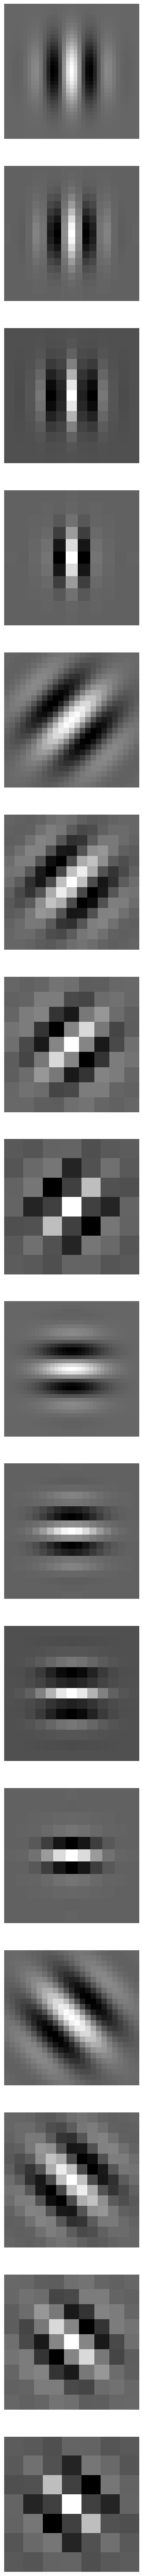

In [9]:
# frequencies = get_frequencies(avg_width , avg_height)
# // 600 
frequencies =  [0.1,0.2,0.3,0.4]
kernels = gabor_kernels_generation(frequencies)


import matplotlib.pyplot as plt
import numpy as np
# Assuming kernels is a list of 2D Gabor kernels

fig, axes = plt.subplots(nrows=len(kernels), figsize=(5, 5*len(kernels)))

for ax, kernel in zip(axes, kernels):
    print(kernel.shape)
    ax.imshow(np.real(kernel), cmap='gray')
    ax.axis('off')

plt.show()

# generate the features from applying the filters to the images

In [ ]:
import pandas as pd
import numpy as np
import skimage as ski
import scipy.ndimage
import os
frequencies = get_frequencies(avg_width , avg_height)
print(frequencies) 


kernels = gabor_kernels_generation(frequencies[1:])
thetas = [0 , np.pi/4 , np.pi/2 , 3*np.pi/4] # mentioned in the papers  0  , 45 , 90 , 135
  
folder_name = ["IBM Plex Sans Arabic" ,"Lemonada" , "Marhey" , "Scheherazade New" ]
columns = ["area_ratio"]
for j in range(1 , 17):
    columns.append("gabor_mean_" + str(j))
    columns.append("gabor_std_" + str(j))
    columns.append("gabor_energy_" + str(j)) 

columns.append("font_type")
features = pd.DataFrame(columns = columns)

img_index =0 
for j in range(0 , 4) : 
    for i in range(0,200): 
        pathname= '../../data/processed/fonts-dataset/' + folder_name[j] + '/' + str(i) + '.jpeg' 
        if os.path.exists(pathname):
            img = ski.io.imread(pathname)

            area = get_area_ratio(img)
            img = resize_image(img , avg_width , avg_height)
            gray_image = convert_to_grayscale(img)
            feature_vect = apply_gabor_filters(gray_image , thetas , [0.1,0.2,0.3,0.4])

            features = pd.concat([features , pd.DataFrame([np.concatenate([[area] , feature_vect , [j]])] , columns = columns)])
        

features.to_csv('./features.csv')

<mark> below are some test code the GLCM  and LBP <mark>

In [11]:
from skimage.feature import graycomatrix, graycoprops
from skimage import io, color ,img_as_ubyte
from scipy.stats import entropy
# Load the image
image = io.imread('../../data/raw/fonts-dataset/Scheherazade New/0.jpeg')
image2 = io.imread('../../data/raw/fonts-dataset/Marhey/0.jpeg')

# Convert the image to grayscale
gray_image = color.rgb2gray(image)
gray_image2 = color.rgb2gray(image2)
gray_image = img_as_ubyte(gray_image)
gray_image2 = img_as_ubyte(gray_image2)
# Compute the GLCM
glcm = graycomatrix(gray_image, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
glcm2 = graycomatrix(gray_image2, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)

# Compute GLCM properties
contrast = graycoprops(glcm, 'contrast')[0, 0]
dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
energy = graycoprops(glcm, 'energy')[0, 0]
correlation = graycoprops(glcm, 'correlation')[0, 0]


zcontrast = graycoprops(glcm2, 'contrast')[0, 0]
zdissimilarity = graycoprops(glcm2, 'dissimilarity')[0, 0]
zhomogeneity = graycoprops(glcm2, 'homogeneity')[0, 0]
zenergy = graycoprops(glcm2, 'energy')[0, 0]
zcorrelation = graycoprops(glcm2, 'correlation')[0, 0]

print('Contrast:', contrast)
print('Dissimilarity:', dissimilarity)
print('Homogeneity:', homogeneity)
print('Energy:', energy)
print('Correlation:', correlation)
entropy_val = entropy(glcm.flatten())

print('Entropy:', entropy_val)


print('Contrast:', zcontrast)
print('Dissimilarity:', zdissimilarity)
print('Homogeneity:', zhomogeneity)
print('Energy:', zenergy)
print('Correlation:', zcorrelation)
entropy_val = entropy(glcm2.flatten())

print('Entropy:', entropy_val)





Contrast: 470.5321401210781
Dissimilarity: 3.587182544482653
Homogeneity: 0.9206964350422097
Energy: 0.8967399487413138
Correlation: 0.42014300227973694
Entropy: 1.0098379318539468
Contrast: 118.67024659143931
Dissimilarity: 0.9463904105249215
Homogeneity: 0.9769916410131136
Energy: 0.9715952301826815
Correlation: 0.33160901045448915
Entropy: 0.3249014037660774


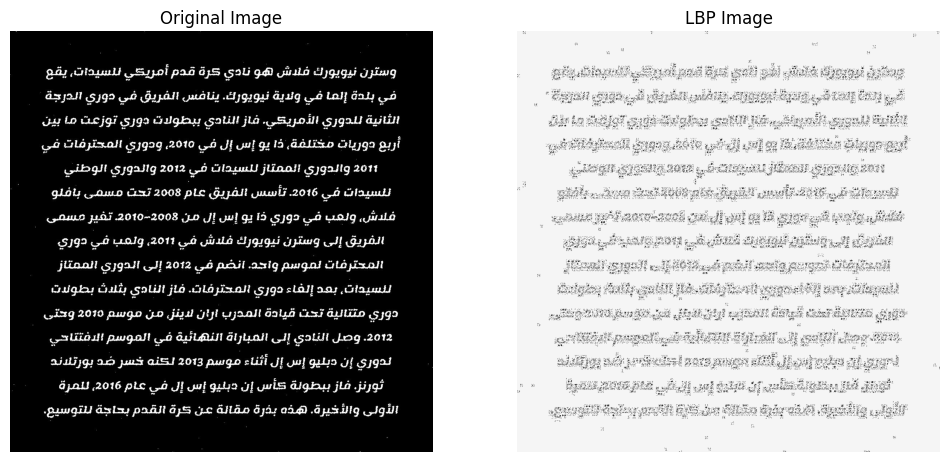

In [7]:
from skimage import io
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

# Load the image
image = io.imread('../../data/processed/fonts-dataset/Lemonada/920.jpeg')

# Convert the image to grayscale

# Settings for LBP
radius = 3
n_points = 8 * radius

# Compute LBP
lbp = local_binary_pattern(image, n_points, radius, method="uniform")

# Display the original image and LBP
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(image, cmap='gray')
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(lbp, cmap='gray')
ax2.set_title('LBP Image')
ax2.axis('off')

plt.show()